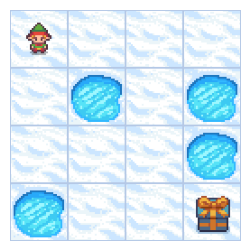

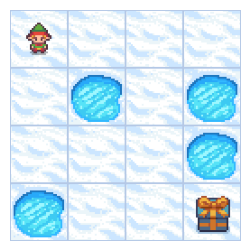

In [10]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)

        super().__init__(env)
        self.env = env

    def reset(self):
        state, _ = self.env.reset()
        return state

    # step 就是進行了一次行動
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #走一步扣一分,逼迫机器人尽快结束游戏
        # 改成 -2
        if not over:
            reward = -2

        #掉坑扣分
        if over and reward == 0:
            reward = -500

        return state, reward, over

    def show(self):
        import numpy as np
        from matplotlib import pyplot as plt
        from IPython.display import clear_output, display

        # 取得 rgb_array
        img = self.env.render()

        # 保證是 numpy 陣列
        if not isinstance(img, np.ndarray):
            img = np.array(img)

        # 第一次呼叫時建立 fig/ax
        if not hasattr(self, '_fig_ax'):
            self._fig_ax = plt.subplots(figsize=(3, 3))
        fig, ax = self._fig_ax

        # 清除上一張、畫新圖
        ax.clear()
        ax.imshow(img)
        ax.axis('off')

        # 利用 IPython 介面更新
        clear_output(wait=True)
        display(fig)

        # 暫停一下讓畫面有機會刷新
        plt.pause(0.5)


env = MyWrapper()

env.reset()

env.show()



In [11]:
import numpy as np

#初始化Q表,定义了每个状态下每个动作的价值
# 最後要優化的目標
Q = np.zeros((16, 4))

Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [12]:
from IPython.display import clear_output
import random
from typing import Tuple

# 定義 transition 型別： (state, action, reward, next_state, done)
Transition = Tuple[int, int, float, int, bool]

def play(
    epsilon: float = 0.1,
    show: bool = False
) -> Tuple[list[Transition], float]:
    transitions: list[Transition] = []
    state = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        # ε-greedy 選擇
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(Q[state].argmax())

        # 執行動作
        next_state, reward, done = env.step(action)
        transitions.append((state, action, reward, next_state, done))

        total_reward += reward
        state = next_state

        # 可選渲染
        if show:
            clear_output(wait=True)
            env.show()

    return transitions, total_reward


play()[-1]

-692.0

In [13]:
NUM_EPOCHS = 5000       # 訓練輪數

def train(
    n: int = 5,
    epochs: int = NUM_EPOCHS,
    alpha: float = 0.01,
    gamma: float = 0.9
):
    """
    使用 n-step TD return 更新 Q-table
    """
    for epoch in range(epochs + 1):
        transitions, _ = play(epsilon=0.1, show=False)
        T = len(transitions)

        # transitions: list of (s, a, r, s_next, done)
        for i in range(T):
            s, a, _, _, _ = transitions[i]
            
            # 1) 計算前 n 步的折扣 reward
            G = 0.0
            for k in range(n):
                if i + k < T:
                    G += (gamma**k) * transitions[i + k][2]  # reward at i+k
                else:
                    break
            
            # 2) 若還沒走到末端，就加上 bootstrapping
            if i + n < T and not transitions[i + n - 1][4]:
                s_n, _, _, _, _ = transitions[i + n]
                G += (gamma**n) * Q[s_n].max()
            
            # 3) 更新 Q
            current = Q[s, a]
            Q[s, a] += alpha * (G - current)

        # 定期評估
        if epoch % 100 == 0:
            avg_reward = sum(play(epsilon=0.0, show=False)[1] for _ in range(20)) / 20
            print(f"Epoch {epoch}: avg_reward = {avg_reward:.2f}")


train()

Epoch 0: avg_reward = -698.00
Epoch 100: avg_reward = -9.00
Epoch 200: avg_reward = -9.00
Epoch 300: avg_reward = -9.00
Epoch 400: avg_reward = -9.00
Epoch 500: avg_reward = -698.00
Epoch 600: avg_reward = -9.00
Epoch 700: avg_reward = -698.00
Epoch 800: avg_reward = -698.00
Epoch 900: avg_reward = -698.00
Epoch 1000: avg_reward = -698.00
Epoch 1100: avg_reward = -698.00
Epoch 1200: avg_reward = -698.00
Epoch 1300: avg_reward = -698.00
Epoch 1400: avg_reward = -698.00
Epoch 1500: avg_reward = -698.00
Epoch 1600: avg_reward = -698.00
Epoch 1700: avg_reward = -9.00
Epoch 1800: avg_reward = -9.00
Epoch 1900: avg_reward = -9.00
Epoch 2000: avg_reward = -9.00
Epoch 2100: avg_reward = -698.00
Epoch 2200: avg_reward = -698.00
Epoch 2300: avg_reward = -698.00
Epoch 2400: avg_reward = -9.00
Epoch 2500: avg_reward = -698.00
Epoch 2600: avg_reward = -698.00
Epoch 2700: avg_reward = -698.00
Epoch 2800: avg_reward = -698.00
Epoch 2900: avg_reward = -698.00
Epoch 3000: avg_reward = -698.00
Epoch 310

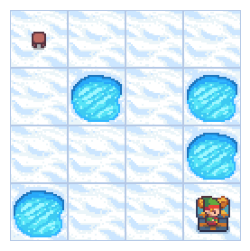

-9.0

In [14]:
play(show=True, epsilon=0.0)[-1]